## Hard disks

#### Check ergodic hyothesis by showing equiprobability of 3 configs using direct sampling, Markov chain sampling and classical molecular dynamics

![Check equiprobability](figs/jwbqZdGXEeWvxwo5BbZD3w_4354c03659c2938026c0fcd2800d8b0c_smac_images_DM2_figure_boxes.png)

#### 1. using direct sampling

In [5]:
from tqdm import tqdm_notebook as tqdm
import random, math


In [6]:
def direct_disks_box(N, sigma):
    condition = False
    while condition == False:
        # random coord of 1st disk sampled in (sigma, 1.0 - sigma) in order not to touch the wall
        L = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))]
        # 3 remaining coord for the other disks
        for k in range(1, N):
            a = (random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))
            min_dist = min(math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for b in L)
            if min_dist < 2.0 * sigma: # overlap between disks
                condition = False
                #print("break after k = ", k)
                break # tabula rasa
            else:
                L.append(a)
                condition = True
    return L

'''
Check for equi-probability of configs a, b, c
are they all predicted with equal frequency by direct_disks_box()?
'''
for _ in range(3):
    sigma = 0.15
    del_xy = 0.05 #0.10 #0.05
    n_runs = 10**5
    conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
    conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
    conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))
    configurations = [conf_a, conf_b, conf_c]
    hits = {conf_a: 0, conf_b: 0, conf_c: 0}
    #for _ in range(10):
    for run in tqdm(range(n_runs)):
        # direct sampling of a legal config [(x1,y1),(x2,y2),(x3,y3),(x4,y4)]
        x_vec = direct_disks_box(4, sigma)

        # for each of conf_a, conf_b, confc
        for conf in configurations:
            condition_hit = True
            # for each HD center of current config (a,b or c)
            for b in conf:
                # max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in x_vec 
                # distance between current disk and every disk of directly sampled xvec config
                # max(...): only the largest distance, taken along x or y axis, is considered
                # min(...) < del_xy : considering the closest HD of xvec, is the distance smaller than del_xy?
                condition_b = min(max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in x_vec) < del_xy
                condition_hit *= condition_b # if yes, condition_hit = True
            # if condition_hit is still True after testing all disks of config `conf`
            if condition_hit:
                #print("run=",run)
                # increment number of hits for config `conf`
                hits[conf] += 1

    for conf in configurations:
        print (conf, hits[conf])

<ipython-input-6-ed8c1ca33d06>:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for run in tqdm(range(n_runs)):



((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 7
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 9
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 14



((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 8
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 11
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 16



((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 9
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 12
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 10


In [ ]:
sigma = 0.15,  del_xy = 0.05
n_runs 10**4: 0 0 0   0 0 0   0 0 0
n_runs 10**5: (15 18 19) (10 7 9) (6 13 11)
n_runs 10**6:(98, 103, 99) (117, 128, 104) (122,115,99)

sigma = 0.15, del_xy = 0.10
n_runs 10**4: (174,82,92) (207,93,109) (190,94,79)
n_runs 10**5: (1905, 965,997) (1868,930,1052) (1837,909,975)
n_runs 10**6: (19060  9206  9961) (18990 9102 10047) (19197 9294 10087)

#### 2. using Markov chain sampling

In [11]:
'''
Check for equi-probability of configs a, b, c
are they all predicted with equal frequency using a Markov chain?
'''
from tqdm import tqdm_notebook as tqdm
import random, math

n_runs = 3

sigma = 0.15
del_xy = 0.05

n_steps = 10**6

conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))
configurations = [conf_a, conf_b, conf_c]

for run in range(n_runs):

    hits = {conf_a: 0, conf_b: 0, conf_c: 0}

    # markov sampling of a legal config [(x1,y1),(x2,y2),(x3,y3),(x4,y4)]:
    # initial config of all disks
    xvec = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
    #xvec = [[0.2, 0.2], [0.5, 0.2], [0.8, 0.2], [0.75, 0.75]]
    # sigma = 0.15 # radius of a disk
    sigma_sq = sigma ** 2
    delta = 0.1
    #n_steps = 1000
    for steps in tqdm(range(n_steps)):
        a = random.choice(xvec) # choose one of the disks
        # move it
        b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
        # smallest distance between moved disk and any other disk
        min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in xvec if c != a)
        # shortest distance to any wall
        box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
        # test if no collision
        if not (box_cond or min_dist < 4.0 * sigma ** 2):
            a[:] = b # if OK update => L will be updated with new position of initially chosen disk `a`
            
            # xvec contains a legal config because of broadcasting a[:]
            # testing configs conf_a, conf_b, conf_c
    
            # for each of conf_a, conf_b, confc
            for conf in configurations:
                condition_hit = True
                # for each HD center of current config (a,b or c)
                for b in conf:
                    # max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in x_vec 
                    # distance between current disk and every disk of directly sampled xvec config
                    # max(...): only the largest distance, taken along x or y axis, is considered
                    # min(...) < del_xy : considering the closest HD of xvec, is the distance smaller than del_xy?
                    condition_b = min(max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in xvec) < del_xy
                    condition_hit *= condition_b # if yes, condition_hit = True
                # if condition_hit is still True after testing all disks of config `conf`
                if condition_hit:
                    #print("run=",run)
                    # increment number of hits for config `conf`
                    hits[conf] += 1

    for conf in configurations:
        print (conf, hits[conf])    

<ipython-input-11-20e45edce1bd>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for steps in tqdm(range(n_steps)):



((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 100
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 82
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 75



((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 106
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 96
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 99



((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 147
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 90
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 98


Interestingly, when starting from a config that is very different from configs a b or c (such as : xvec = [[0.2, 0.2], [0.5, 0.2], [0.8, 0.2], [0.75, 0.75]]), we find also similar results, which means that the Markov chain length is greater that its correlation time.

For a given number steps, Markov chain sampling produces some rejected states, so the number of hits is somewhat lower than direct sampling (which, for each steps, will go into a while loop until a legal config is found)

In [ ]:
sigma = 0.15,  del_xy = 0.05

direct sampling (previous question):
n_runs 10**4: (0 0 0)   (0 0 0)   (0 0 0)
n_runs 10**5: (15 18 19) (10 7 9) (6 13 11)
n_runs 10**6:(98, 103, 99) (117, 128, 104) (122,115,99)

Markov sampling:
n_runs = 10**4 (0 0 1) (0 0 0) (0 0 0)
n_runs=10**5 (11 8 19 ) (6 6 18) (8 8 9)
n_runs=10**6 (83 86 122) (88 88 86) (79 75 96)
n_runs=10**7 (1020 775 838) (952 779 919) (912 770 836)




#### 3. using classical MD

In [40]:
'''
Check for equi-probability of configs a, b, c
are they all predicted with equal frequency using a classical MD simulation?
'''
import math, pylab

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))
configurations = [conf_a, conf_b, conf_c]
hits = {conf_a: 0, conf_b: 0, conf_c: 0}
del_xy = 0.10

# initial state
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]

singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
sigma = 0.10
t = 0.0
n_events = 5000000
for event in tqdm(range(n_events)):
    if event % 100000 == 0:
        print (event)
    # wall collision times and pair collision times given positions and velocities from previous step
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t_previous = t
    
    
    # range(int(t + 1), int(t + next_event + 1)) = range(1,1) if last event occurred in the same interval as t_previous
    # we need int(t + next_event + 1) > int(t + 1) to go into the for loop and test if we sample configurations
    # If several events all happened between t=1 and t= 1.999... we wil not go into the for loop.
    # Check using:
    # print("t_previous = ", t_previous, "t=", t, "int(t + 1), int(t + next_event + 1) ", int(t + 1), int(t + next_event + 1))
    for inter_times in range(int(t + 1), int(t + next_event + 1)):
        #print("inter_times = ", inter_times)
        del_t = inter_times - t_previous
        
        # update positions
        for k, l in singles:
            pos[k][l] += vel[k][l] * del_t
        t_previous = inter_times
        
        # check if configs a,b or c are sampled (within del_xy error)
        for conf in configurations:
            condition_hit = True
            for b in conf:
                condition_b = min(max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in pos) < del_xy
                condition_hit *= condition_b
            if condition_hit:
                #print("conf = ", conf, "condition hit at t = ", t)
                hits[conf] += 1
                
    # resume calculation of trajectories after latest event
    t += next_event
    del_t = t - t_previous
    for k, l in singles:
        pos[k][l] += vel[k][l] * del_t
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else:
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2):
            vel[a][k] += e_perp[k] * scal
            vel[b][k] -= e_perp[k] * scal

for conf in configurations:
    print("t=", t) # 5000000 =>
    print (conf, hits[conf])

<ipython-input-40-d5681bc928f7>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for event in tqdm(range(n_events)):


0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000

t= 611872.6128303948
((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 667
t= 611872.6128303948
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 634
t= 611872.6128303948
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 672


### Histogram of center of a disk

#### 1. using direct sampling

In [10]:
from matplotlib import pyplot as plt

In [43]:
import random

def direct_disks_box(N, sigma):
    overlap = True
    while overlap == True:
        L = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))]
        for k in range(1, N):
            a = (random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))
            min_dist_sq = min(((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for b in L)
            if min_dist_sq < 4.0 * sigma ** 2:
                overlap = True
                break
            else:
                overlap = False
                L.append(a)
    return L


N = 4
sigma = 0#0.1197
n_runs = 1000000
histo_data = []
for run in tqdm(range(n_runs)):
    pos = direct_disks_box(N, sigma)
    for k in range(N):
        histo_data.append(pos[k][0])


<ipython-input-43-da8689e2d9a9>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for run in tqdm(range(n_runs)):


More configurations are available in the corner of the box (leaves more space for other disks)

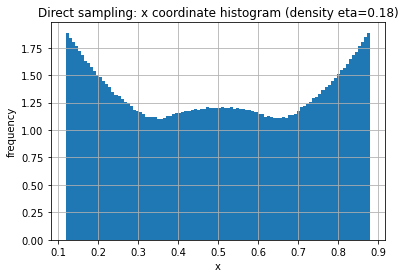

In [42]:
plt.hist(histo_data, bins=100, density=True)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Direct sampling: x coordinate histogram (density eta=0.18)')
plt.grid()
plt.savefig('direct_disks_histo.png')
plt.show()

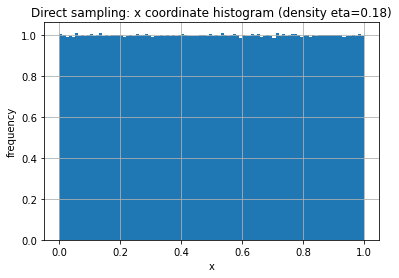

In [44]:
# eta = 0 => flat histogram

plt.hist(histo_data, bins=100, density=True)#, normed=True)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Direct sampling: x coordinate histogram (density eta=0.18)')
plt.grid()
plt.savefig('direct_disks_histo.png')
plt.show()


#### 2. using Markov chain sampling

In [48]:
import random
from matplotlib import pyplot as plt

L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
sigma = 0.1197
sigma_sq = sigma ** 2
delta = 0.1
n_steps = 2000000

N = 4
histo_data = []
for steps in tqdm(range(n_steps)):
    a = random.choice(L)
    b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
    min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a)
    box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
    
    if not (box_cond or min_dist < 4.0 * sigma ** 2):
        a[:] = b
    #else:
    #    print("*** steps ***", steps)
    #print (L)
    for k in range(N):
        histo_data.append(L[k][0])



<ipython-input-48-3f2af636a5cf>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for steps in tqdm(range(n_steps)):


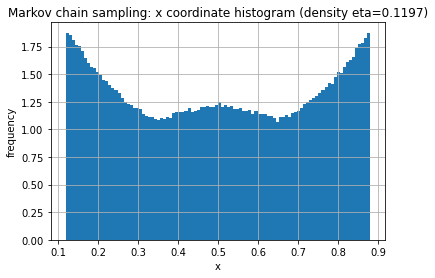

In [49]:
plt.hist(histo_data, bins=100, density=True)#, normed=True)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('Markov chain sampling: x coordinate histogram (density eta=0.1197)')
plt.grid()
plt.savefig('markov_disks_histo.png')
plt.show()


#### 3. using classical MD

In [63]:
import math

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

# initial state
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]

singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
sigma = 0.1197
t = 0.0
n_events = 5000000

N = 4
histo_data = []



for event in tqdm(range(n_events)):
#    if event % 100000 == 0:
#        print (event)
    # wall collision times and pair collision times given positions and velocities from previous step
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t_previous = t
    
    
    # range(int(t + 1), int(t + next_event + 1)) = range(1,1) if last event occurred in the same interval as t_previous
    # we need int(t + next_event + 1) > int(t + 1) to go into the for loop and test if we sample configurations
    # If several events all happened between t=1 and t= 1.999... we wil not go into the for loop.
    # Check using:
    # print("t_previous = ", t_previous, "t=", t, "int(t + 1), int(t + next_event + 1) ", int(t + 1), int(t + next_event + 1))
    for inter_times in range(int(t + 1), int(t + next_event + 1)):
        #print("inter_times = ", inter_times)
        del_t = inter_times - t_previous
        
        # update positions
        for k, l in singles:
            pos[k][l] += vel[k][l] * del_t
        t_previous = inter_times

        for k in range(N):
            histo_data.append(pos[k][0])

                
    # resume calculation of trajectories after latest event
    t += next_event
    del_t = t - t_previous
    for k, l in singles:
        pos[k][l] += vel[k][l] * del_t
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else:
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2):
            vel[a][k] += e_perp[k] * scal
            vel[b][k] -= e_perp[k] * scal



<ipython-input-63-e0dcb20706bf>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for event in tqdm(range(n_events)):


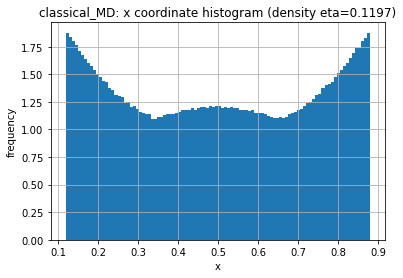

In [64]:
plt.hist(histo_data, bins=100, density=True)#, normed=True)
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('classical_MD: x coordinate histogram (density eta=0.1197)')
plt.grid()
plt.savefig('events_disks_histo.png')
plt.show()
